# An Introduction to Federated Learning with Flower

Welcome to this Flower federated learning tutorial!

In this notebook, we'll build a federated learning system using Flower and PyTorch. In part 1, we use PyTorch for the model training pipeline and data loading. In part 2, we continue to federate the PyTorch-based pipeline using Flower.

Let's start!

## Step 0: What is Flower ?

You can have a look on the Flower's [documentation](https://flower.dev/docs/), on the github [repository](https://github.com/adap/flower) (2.4k stars, 500 forks) or on the [paper](https://arxiv.org/pdf/2007.14390.pdf) released on arXiv. 

*Flower* is a FL framework that supports large-cohort training and evaluation, both on real edge devices and on single-node or multi-node compute clusters. This unlocks scalable algorithmic research of real-world system conditions such as limited computational resources which are common for typical FL workloads.

The team building it is dynamic and proposes a large variety of notebooks to get started with their framework!


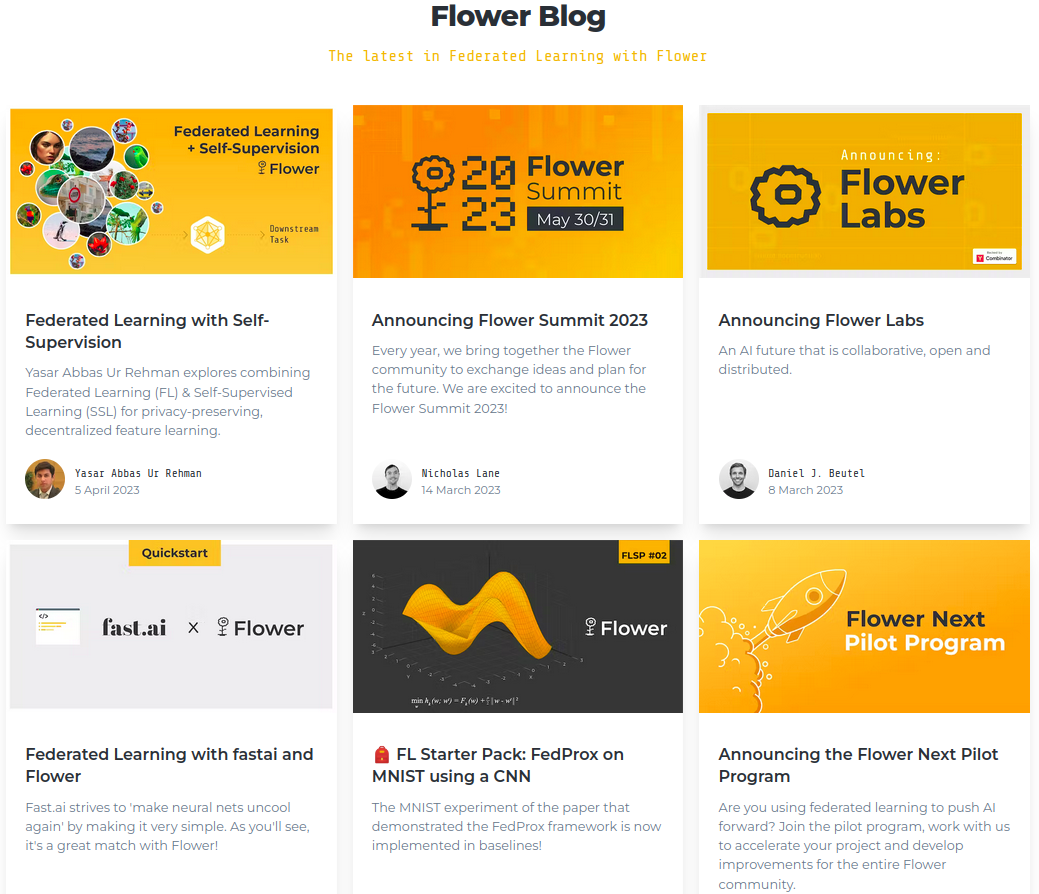

### Design goals 


1.   Scalable: Given that real-world FL would encounter a large number of clients, Flower should scale to a large number of
concurrent clients to foster research on a realistic scale.
2.   Client-agnostic: Given the heterogeneous environment on
mobile clients, Flower should be interoperable with different
programming languages, operating systems, and hardware.
3.   Communication-agnostic: Given the heterogeneous connectivity settings, Flower should allow different serialization
and communication approaches.
4.   Privacy-agnostic: Different FL settings (cross-device, cross-
silo) have different privacy requirements (secure aggregation, differential privacy). Flower should support common
approaches whilst not be prescriptive about their usage.
5.   Flexible: Given the rate of change in FL and the velocity
of the general ML ecosystem, Flower should be flexible to
enable both experimental research and adoption of recently
proposed approaches with low engineering overhead.

## Step 1: Preparation

Before we begin with any actual code, let's make sure that we have everything we need.

### Installing dependencies

Next, we install the necessary packages for PyTorch (`torch` and `torchvision`) and Flower (`flwr`):

In [1]:
# %pip install -q flwr[simulation] torch torchvision matplotlib 

Now that we have all dependencies installed, we can import everything we need for this tutorial:

In [2]:
from collections import OrderedDict
from typing import List, Tuple

import copy

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10, MNIST, EMNIST

import flwr as fl
from flwr.common import Metrics

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

#torch.cuda.set_device(0) 

Training on cpu using PyTorch 2.0.1+cu118 and Flower 1.4.0


It is possible to switch to a runtime that has GPU acceleration enabled (on Google Colab: `Runtime > Change runtime type > Hardware acclerator: GPU > Save`). Note, however, that Google Colab is not always able to offer GPU acceleration. If you see an error related to GPU availability in one of the following sections, consider switching back to CPU-based execution by setting `DEVICE = torch.device("cpu")`. If the runtime has GPU acceleration enabled, you should see the output `Training on cuda`, otherwise it'll say `Training on cpu`.


### Loading the data

Federated learning can be applied to many different types of tasks across different domains. In this tutorial, we introduce federated learning by training a simple convolutional neural network (CNN) on the popular CIFAR-10 dataset. CIFAR-10 can be used to train image classifiers that distinguish between images from ten different classes:

In [3]:
dataset = "CIFAR10"

if dataset == "MNIST":
    CLASSES = ("0","1","2","3","4","5","6","7","8","9")
elif dataset == "CIFAR10":
    CLASSES = ("plane","car","bird","cat","deer","dog","frog","horse","ship","truck")
elif dataset == "EMNIST":
    CLASSES = ("0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z", "a", "b", "d", "e", "f", "g", "h", "n", "q", "r", "t")


We simulate having multiple datasets from multiple organizations (also called the "cross-silo" setting in federated learning) by splitting the original CIFAR-10 dataset into multiple partitions. Each partition will represent the data from a single organization. We're doing this purely for experimentation purposes, in the real world there's no need for data splitting because each organization already has their own data (so the data is naturally partitioned).

Each organization will act as a client in the federated learning system. So having ten organizations participate in a federation means having ten clients connected to the federated learning server:


In [4]:
NUM_CLIENTS = 20
NUM_EPOCHS = 15
DIRICHLET_COEF = 0.35 # Degree of heterogeneity, the greater it is, the more homogeneous will be the clients.
BATCH_SIZE = 128
LR = 0.1
NUM_LOCAL_EPOCHS = 1
NUM_COMPONENTS = 3 # Following Marfocq and al. 2021

### Heterogeneous split of the data

We need to create heterogeneous clients, to do so we rely on a Dirichlet distribution to splits the dataset.

Specifically, we sample $p_k \sim Dir_N (\beta)$ and allocate a $p_{k,j}$ proportion of the instances of class $k$ to party $j$. Here $Dir(\cdot)$ denotes
the Dirichlet distribution and $\beta$ is a concentration parameter ($\beta > 0$). An advantage of this approach is that we can flexibly change the imbalance level by varying the concentration parameter $\beta$. If $\beta$ is set to a smaller value, then the partition is more unbalanced

See [Federated Learning on Non-IID Data Silos: An Experimental Study](https://arxiv.org/pdf/2102.02079.pdf) by Li et al, 2021.

In [5]:
from numpy.random import dirichlet
import random

def non_iid_split(train_data, nb_devices, dirichlet_coef=1):
    """Splits the training data by target values (leads to a highly non-iid data distribution) using a Dirichlet 
        distribution."""
    unique_values = {}
    targets = train_data.targets
    n = len(targets)

    # Splitting the dataset by target value.
    if not torch.is_tensor(targets):
        targets = torch.Tensor(targets)
    for i in range(n):
        if targets[i].item() in unique_values:
            unique_values[targets[i].item()] = np.append(unique_values[targets[i].item()], [i])
        else:
            unique_values[targets[i].item()] = np.array([i])
    nb_labels = len(unique_values)

    nb_points_by_clients = n // nb_devices
    matrix = (dirichlet([dirichlet_coef] * nb_labels, size=nb_devices)  * (nb_points_by_clients+2)).astype(int)# 1 line = 1 worker
    ordered_indices = sorted(unique_values.values(), key=len)
    split = []
    for i in range(nb_devices):
        indices_for_client_i = []
        for j in range(nb_labels):
            indices_by_label = ordered_indices[j]
            indices_for_client_i += random.sample(list(indices_by_label), matrix[i][j]) # Join lists
        split.append(np.array(indices_for_client_i))

    return split


Let's now load the CIFAR-10 training and test set, partition them into ten smaller datasets (each split into training and validation set), and wrap the resulting partitions by creating a PyTorch `DataLoader` for each of them:

In [6]:
import math
from torch.utils.data import DataLoader, Subset, RandomSampler

def load_datasets(nb_clients):
    # Download and transform CIFAR10/MNIST (train and test)

    if dataset == "MNIST":
        transform = transforms.Compose([
          torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.1307,), (0.3081,))]
          )
        trainset = MNIST("./dataset", train=True, download=True, transform=transform)
        testset = MNIST("./dataset", train=False, download=True, transform=transform)
    elif dataset == "CIFAR10":
        transform = transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
        )
        trainset = CIFAR10("./dataset", train=True, download=True, transform=transform)
        testset = CIFAR10("./dataset", train=False, download=True, transform=transform)
    elif dataset == "EMNIST":
        transform = transforms.Compose([
          torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5,), (0.5,))]
          )
        trainset = EMNIST("./dataset", train=True, download=True, transform=transform, split="balanced")
        testset = EMNIST("./dataset", train=False, download=True, transform=transform, split="balanced")

    
    
    split = non_iid_split(trainset, nb_clients, DIRICHLET_COEF)
    

    # Split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []
    for indices in split:
        
        random.shuffle(indices)
        
        indices_train = indices[:math.floor(len(indices)*0.9)]
        indices_val = indices[math.floor(len(indices)*0.9)+1:]
        
        # shuffle = False is necesseray to later mulply the loss of a given item with the corresponding posterior proba.
        trainloaders.append(DataLoader(Subset(trainset, indices_train), batch_size=BATCH_SIZE, 
                                       shuffle=False, 
                                       pin_memory=True if torch.cuda.is_available() else False,
                                       num_workers=2 if torch.cuda.is_available() else 0))
        valloaders.append(DataLoader(Subset(trainset, indices_val), batch_size=BATCH_SIZE,  
                                     shuffle=False, 
                                     pin_memory=True if torch.cuda.is_available() else False,
                                     num_workers=2 if torch.cuda.is_available() else 0))
    testloader = DataLoader(testset, batch_size=BATCH_SIZE, 
                            pin_memory=True if torch.cuda.is_available() else False,
                            num_workers=2 if torch.cuda.is_available() else 0)
    return trainloaders, valloaders, testloader


In [7]:
trainloaders, valloaders, testloader = load_datasets(NUM_CLIENTS)

Files already downloaded and verified
Files already downloaded and verified


We now have a list of ten training sets and ten validation sets (`trainloaders` and `valloaders`) representing the data of ten different organizations. Each `trainloader`/`valloader` pair contains 4500 training examples and 500 validation examples. There's also a single `testloader` (we did not split the test set). Again, this is only necessary for building research or educational systems, actual federated learning systems have their data naturally distributed across multiple partitions.



### Visualisation of client's heterogeneity

Below, we represent the labels' distribution for the firsts three clients. We can see that they are higly heterogeneous.

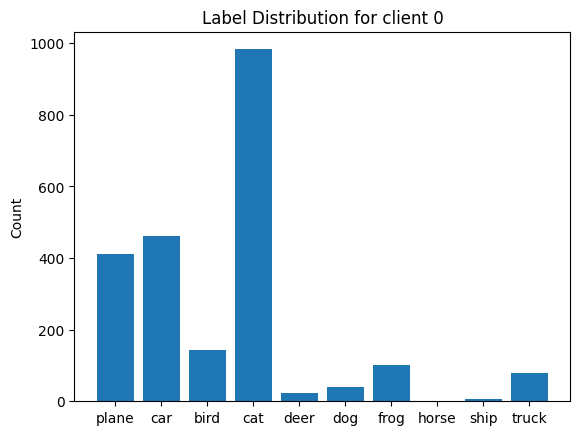

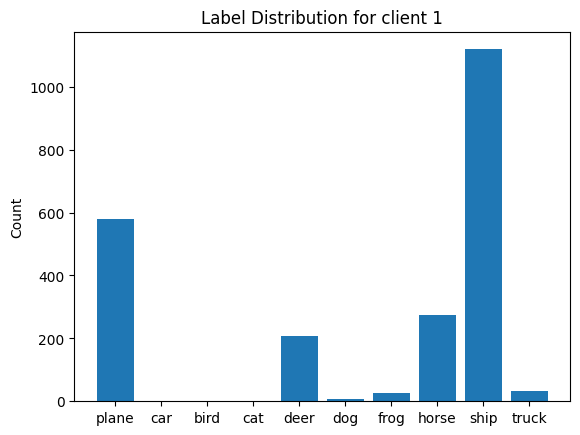

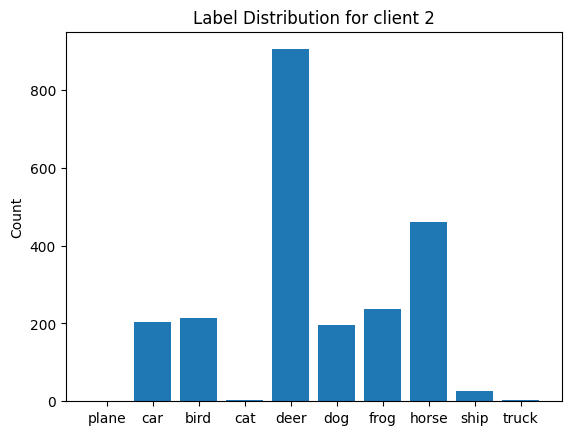

In [8]:
def plot_label_distribution(list_loader, client_id, classes):
    loader = list_loader[client_id]
    labels = np.zeros(len(classes))  
    for images, targets in loader:
        for target in targets:
            labels[target] += 1
    plt.bar(np.arange(len(classes)), labels)
    plt.xticks(np.arange(len(classes)), classes)
    plt.ylabel('Count')
    plt.title('Label Distribution for client {0}'.format(client_id))
    plt.show()
    
plot_label_distribution(trainloaders, 0, CLASSES)
plot_label_distribution(trainloaders, 1, CLASSES)
plot_label_distribution(trainloaders, 2, CLASSES)

Let's take a look at the first batch of images and labels in the first training set (i.e., `trainloaders[0]`) before we move on:

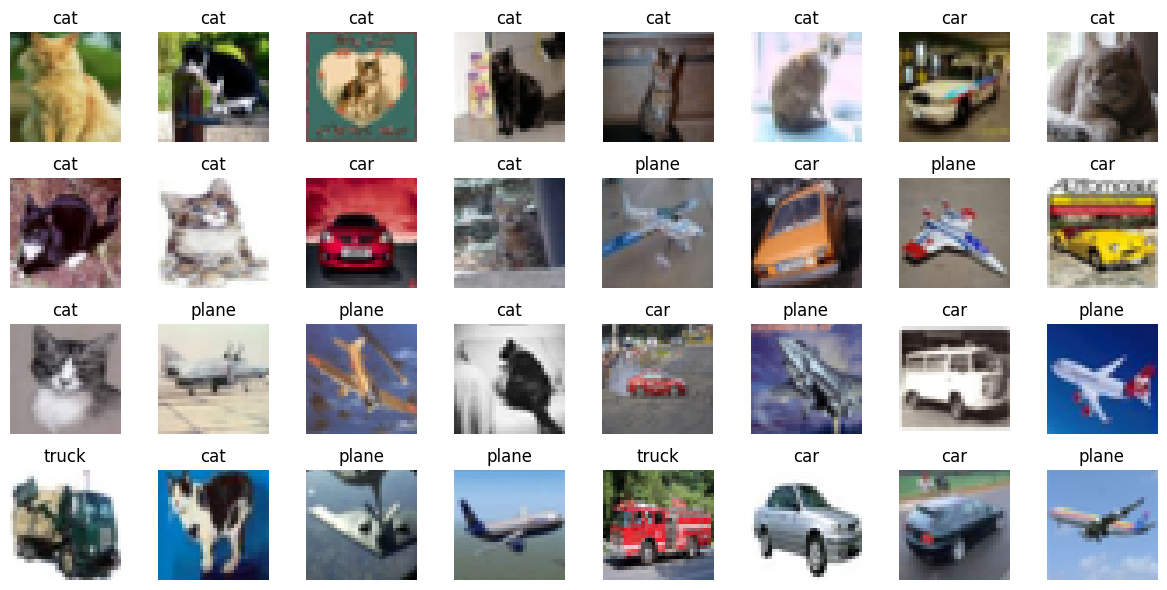

In [9]:
images, labels = next(iter(trainloaders[0]))

# Reshape and convert images to a NumPy array
# matplotlib requires images with the shape (height, width, 3)
images = images.permute(0, 2, 3, 1).numpy()
# Denormalize
images = images / 2 + 0.5

# Create a figure and a grid of subplots
fig, axs = plt.subplots(4, 8, figsize=(12, 6))

# Loop over the images and plot them
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i])
    ax.set_title(CLASSES[labels[i]])
    ax.axis("off")

# Show the plot
fig.tight_layout()
plt.show()

The output above shows a random batch of images from the first `trainloader` in our list of ten `trainloaders`. It also prints the labels associated with each image (i.e., one of the ten possible labels we've seen above). If you run the cell again, you should see another batch of images.

## Step 2: Centralized Training with PyTorch



Next, we're going to use PyTorch to define a simple convolutional neural network. This introduction assumes basic familiarity with PyTorch, so it doesn't cover the PyTorch-related aspects in full detail. If you want to dive deeper into PyTorch, we recommend [*DEEP LEARNING WITH PYTORCH: A 60 MINUTE BLITZ*](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html).


### Defining the model

We use a simple one-layer neural network, the advantage being simplicity and speed. Also, the convex function that we want to minimize is convex.

In [10]:
import torchvision.models as models


def Net():
    n_classes = 10
    model = models.mobilenet_v2(pretrained=True)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, n_classes)
    return model

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        if dataset == "MNIST":
            self.fc = nn.Linear(28 * 28, 10)
        elif dataset == "CIFAR10":
            self.fc = nn.Linear(32 * 32 * 3, 10) # 32x32x3 input features, 10 output classes
        elif dataset == "EMNIST":
            self.fc = nn.Linear(28 * 28, 47)
        
    
    def forward(self, x):
        if dataset in ["MNIST", "EMNIST"]:
            x = x.view(-1, 28 * 28) # Flatten the input
        else:
            x = x.view(-1, 32 * 32 * 3) # Flatten the input
        
        x = self.fc(x)
        return x

Let's continue with the usual training and test functions:

In [12]:
def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=LR)
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


In [13]:
def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

### Training the model

We now have all the basic building blocks we need: a dataset, a model, a training function, and a test function. Let's put them together to train the model on the dataset of one of our organizations (`trainloaders[0]`). This simulates the reality of most machine learning projects today: each organization has their own data and trains models only on this internal data: 

In [14]:
trainloader = trainloaders[0]
valloader = valloaders[0]
net = Net().to(DEVICE)

In [15]:
for epoch in range(NUM_EPOCHS):
    train(net, trainloader, 1)
    loss, accuracy = test(net, valloader)
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")

loss, accuracy = test(net, testloader)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

Epoch 1: validation loss 0.01606618304807977, accuracy 0.43775100401606426
Epoch 2: validation loss 0.023820404068054444, accuracy 0.4457831325301205
Epoch 3: validation loss 0.020183460779458165, accuracy 0.4979919678714859
Epoch 4: validation loss 0.019884977953501016, accuracy 0.5060240963855421
Epoch 5: validation loss 0.01984092317910558, accuracy 0.5100401606425703
Epoch 6: validation loss 0.019673167462329787, accuracy 0.5100401606425703
Epoch 7: validation loss 0.01953013929497286, accuracy 0.5020080321285141
Epoch 8: validation loss 0.01937528403408556, accuracy 0.4979919678714859
Epoch 9: validation loss 0.019232165861321263, accuracy 0.4939759036144578
Epoch 10: validation loss 0.019084047600926166, accuracy 0.5020080321285141
Epoch 11: validation loss 0.01892067821150324, accuracy 0.5100401606425703
Epoch 12: validation loss 0.018744167075099714, accuracy 0.5020080321285141
Epoch 13: validation loss 0.01856318247844895, accuracy 0.4979919678714859
Epoch 14: validation loss 

Training the simple CNN on our CIFAR-10 split for 5 epochs should result in a test set accuracy of about 41%, which is not good, but at the same time, it doesn't really matter for the purposes of this tutorial. The intent was just to show a simplistic centralized training pipeline that sets the stage for what comes next - federated learning!

## Step 3: Federated Learning with Flower

Step 1 demonstrated a simple centralized training pipeline. All data was in one place (i.e., a single `trainloader` and a single `valloader`). Next, we'll simulate a situation where we have multiple datasets in multiple organizations and where we train a model over these organizations using federated learning.

### Updating model parameters

In federated learning, the server sends the global model parameters to the client, and the client updates the local model with the parameters received from the server. It then trains the model on the local data (which changes the model parameters locally) and sends the updated/changed model parameters back to the server (or, alternatively, it sends just the gradients back to the server, not the full model parameters).

We need two helper functions to update the local model with parameters received from the server and to get the updated model parameters from the local model: `set_parameters` and `get_parameters`. The following two functions do just that for the PyTorch model above.

The details of how this works are not really important here (feel free to consult the PyTorch documentation if you want to learn more). In essence, we use `state_dict` to access PyTorch model parameter tensors. The parameter tensors are then converted to/from a list of NumPy ndarray's (which Flower knows how to serialize/deserialize):

In [16]:
def get_parameters_network(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters_network(net, parameters: List[np.ndarray]) -> None:
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)



We will also need to aggregate a list of networks.

In [17]:
def aggregate_networks(models: List[nn.Module], weights: np.array) -> nn.Module:

    all_parameters = [get_parameters_network(net) for net in models]
    aggregated_parameters = [np.sum([weights[n] * all_parameters[n][p] for n in range(len(models))], axis=0) 
              for p in range(len(all_parameters[0]))]

    net = copy.deepcopy(models[0])
    set_parameters_network(net, aggregated_parameters)
    return net

### Implementing a Flower client

With that out of the way, let's move on to the interesting part. Federated learning systems consist of a server and multiple clients. In Flower, we create clients by implementing subclasses of `flwr.client.Client` or `flwr.client.NumPyClient`. We use `NumPyClient` in this tutorial because it is easier to implement and requires us to write less boilerplate.

To implement the Flower client, we create a subclass of `flwr.client.NumPyClient` and implement the three methods `get_parameters`, `fit`, and `evaluate`:

* `get_parameters`: Return the current local model parameters
* `fit`: Receive model parameters from the server, train the model parameters on the local data, and return the (updated) model parameters to the server
* `evaluate`: Receive model parameters from the server, evaluate the model parameters on the local data, and return the evaluation result to the server

We mentioned that our clients will use the previously defined PyTorch components for model training and evaluation. Let's see a simple Flower client implementation that brings everything together:

In [18]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters_network(self.net)

    def fit(self, parameters, config):
        set_parameters_network(self.net, parameters)
        train(self.net, self.trainloader, epochs=NUM_LOCAL_EPOCHS)
        return get_parameters_network(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters_network(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

Our class `FlowerClient` defines how local training/evaluation will be performed and allows Flower to call the local training/evaluation through `fit` and `evaluate`. Each instance of `FlowerClient` represents a *single client* in our federated learning system. Federated learning systems have multiple clients (otherwise, there's not much to federate), so each client will be represented by its own instance of `FlowerClient`. If we have, for example, three clients in our workload, then we'd have three instances of `FlowerClient`. Flower calls `FlowerClient.fit` on the respective instance when the server selects a particular client for training (and `FlowerClient.evaluate` for evaluation).

### Using the Virtual Client Engine

In this notebook, we want to simulate a federated learning system with 10 clients on a single machine. This means that the server and all 10 clients will live on a single machine and share resources such as CPU, GPU, and memory. Having 10 clients would mean having 10 instances of `FlowerClient` in memory. Doing this on a single machine can quickly exhaust the available memory resources, even if only a subset of these clients participates in a single round of federated learning.

In addition to the regular capabilities where server and clients run on multiple machines, Flower, therefore, provides special simulation capabilities that create `FlowerClient` instances only when they are actually necessary for training or evaluation. To enable the Flower framework to create clients when necessary, we need to implement a function called `client_fn` that creates a `FlowerClient` instance on demand. Flower calls `client_fn` whenever it needs an instance of one particular client to call `fit` or `evaluate` (those instances are usually discarded after use, so they should not keep any local state). Clients are identified by a client ID, or short `cid`. The `cid` can be used, for example, to load different local data partitions for different clients, as can be seen below:

In [19]:
def client_fn_FedAvg(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    net = Net().to(DEVICE)

    # Load data (CIFAR-10)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    # Create a  single Flower client representing a single organization
    return FlowerClient(net, trainloader, valloader)

### How to get accuracy?

Flower can automatically aggregate losses returned by individual clients, but it cannot do the same for metrics in the generic metrics dictionary (the one with the `accuracy` key). Metrics dictionaries can contain very different kinds of metrics and even key/value pairs that are not metrics at all, so the framework does not (and can not) know how to handle these automatically.

As users, we need to tell the framework how to handle/aggregate these custom metrics, and we do so by passing metric aggregation functions to the strategy. The strategy will then call these functions whenever it receives fit or evaluate metrics from clients. The two possible functions are `fit_metrics_aggregation_fn` and `evaluate_metrics_aggregation_fn`.

Let's create a simple weighted averaging function to aggregate the `accuracy` metric we return from `evaluate`:

In [20]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

### Starting the training

We now have the class `FlowerClient` which defines client-side training/evaluation and `client_fn` which allows Flower to create `FlowerClient` instances whenever it needs to call `fit` or `evaluate` on one particular client. The last step is to start the actual simulation using `flwr.simulation.start_simulation`. 

The function `start_simulation` accepts a number of arguments, amongst them the `client_fn` used to create `FlowerClient` instances, the number of clients to simulate (`num_clients`), the number of federated learning rounds (`num_rounds`), and the strategy. The strategy encapsulates the federated learning approach/algorithm, for example, *Federated Averaging* (FedAvg).

Flower has a number of built-in strategies, but we can also use our own strategy implementations to customize nearly all aspects of the federated learning approach. For this example, we use the built-in `FedAvg` implementation and customize it using a few basic parameters. The last step is the actual call to `start_simulation` which - you guessed it - starts the simulation:

In [21]:
client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}

print(client_resources)

None


In [22]:
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1,  # Sample 100% of available clients for training
    fraction_evaluate=1,  # Sample 50% of available clients for evaluation
    min_fit_clients=5,  # Never sample less than 10 clients for training
    min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=5,  # Wait until all 10 clients are available
    evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
)

# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}

# Start simulation
result_fedavg = fl.simulation.start_simulation(
    client_fn=client_fn_FedAvg,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_EPOCHS),
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2023-06-06 15:56:33,057 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=15, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=15, round_timeout=None)
2023-06-06 15:56:37,808	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-06 15:56:39,322 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:172.28.0.12': 1.0, 'object_store_memory': 3940165632.0, 'CPU': 2.0, 'memory': 7880331264.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'node:172.28.0.12': 1.0, 'object_store_memory': 3940165632.0, 'CPU': 2.0, 'memory': 7880331264.0}
INFO flwr 2023-06-06 15:56:39,335 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-06-06 15:56:39,337 | server.py:273 | Requesting initial parameters from one random client
INFO:flwr:Requesting initial parameters from one random client
(pid=125221) 2023-06-06 15:56:42.729129: W tensorflow/compil

### Behind the scenes

So how does this work? How does Flower execute this simulation?

When we call `start_simulation`, we tell Flower that there are 10 clients (`num_clients=10`). Flower then goes ahead an asks the `FedAvg` strategy to select clients. `FedAvg` knows that it should select 100% of the available clients (`fraction_fit=1.0`), so it goes ahead and selects 10 random clients (i.e., 100% of 10).

Flower then asks the selected 10 clients to train the model. When the server receives the model parameter updates from the clients, it hands those updates over to the strategy (*FedAvg*) for aggregation. The strategy aggregates those updates and returns the new global model, which then gets used in the next round of federated learning.

We now have a full system that performs federated training and federated evaluation. It uses the `weighted_average` function to aggregate custom evaluation metrics and calculates a single `accuracy` metric across all clients on the server side.

The other two categories of metrics (`losses_centralized` and `metrics_centralized`) are still empty because they only apply when centralized evaluation is being used. Part two of the Flower tutorial will cover centralized evaluation.

### Plotting error and accuracy

Now, it remains to plot the logarithm excess loss and the training accuracy.

In [23]:
def plot_metrics(list_losses, liss_accuracies, list_names):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    for (loss, acc, name) in zip(list_losses, liss_accuracies, list_names):
        ax[0].plot(loss, label=name)
        ax[0].set_title('log10(Training Loss)')
        ax[0].set_xlabel('Epoch')
        ax[0].set_ylabel('log10(Train loss)')
        ax[0].set_yscale('log')
        ax[0].legend()
        ax[1].plot(acc, label=name)
        ax[1].set_title('Test Accuracy')
        ax[1].set_xlabel('Epoch')
        ax[1].set_ylabel('Accuracy')
        ax[1].legend()
    plt.show()

In [24]:
result_fedavg

History (loss, distributed):
	round 1: 0.015276431127724399
	round 2: 0.014802366782383747
	round 3: 0.014576034971987867
	round 4: 0.014556348539260498
	round 5: 0.014477796104538396
	round 6: 0.014397693398487139
	round 7: 0.014305189934121557
	round 8: 0.01424020397136489
	round 9: 0.014178081042316543
	round 10: 0.01418958593563861
	round 11: 0.014074047430452097
	round 12: 0.014096156157642963
	round 13: 0.014045782500960263
	round 14: 0.014041831574765554
	round 15: 0.01400768790379107
History (metrics, distributed, evaluate):
{'accuracy': [(1, 0.3222891566265061), (2, 0.34558232931726907), (3, 0.3636546184738956), (4, 0.3622489959839358), (5, 0.36887550200803204), (6, 0.3753012048192771), (7, 0.3755020080321286), (8, 0.3825301204819277), (9, 0.38473895582329315), (10, 0.38574297188755025), (11, 0.38855421686746994), (12, 0.3885542168674699), (13, 0.3927710843373494), (14, 0.3911646586345382), (15, 0.39196787148594386)]}

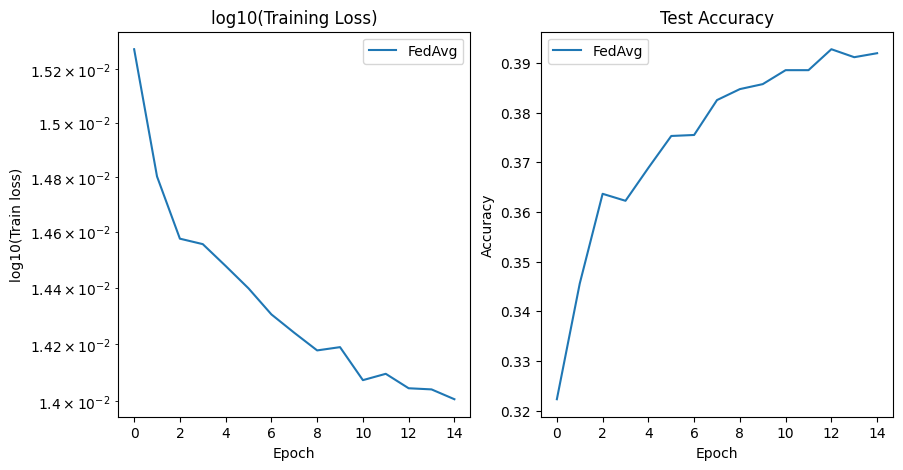

In [25]:
losses_fedavg = [key[1] for key in result_fedavg.losses_distributed]
accuracies_fedavg = [key[1] for key in result_fedavg.metrics_distributed['accuracy']]


plot_metrics([losses_fedavg], [accuracies_fedavg], ["FedAvg"])

## Step 4: FedEM, an algorithm to train personalized model



### Implementing Flower clients adapted to FedEM

In [26]:
def zero_like(net) -> List[np.ndarray]:
    return [np.zeros_like(val.cpu().numpy()) for _, val in net.state_dict().items()]


In [27]:
class FlowerClientFedEM(fl.client.NumPyClient):
    def __init__(self, cid, trainloader, valloader):
        self.cid = cid
        self.trainloader = trainloader
        self.valloader = valloader

        self.local_epochs = NUM_LOCAL_EPOCHS
        self.num_components = NUM_COMPONENTS
        self.lr = LR

    def train(self, models, mixture_weights, verbose=False):
        """Train the network on the training set."""
        print("Start train.")
        
        criterion = torch.nn.CrossEntropyLoss(reduce=False)
        trained_models = [] # To store the m updated models.

        
        # Computing the mixture'weights
        probas = [[] for m in range(self.num_components)]
        for images, labels in self.trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            for m in range(self.num_components):
                net = models[m]
                net.eval()
                with torch.no_grad():
                    outputs = net(images)
                    loss = criterion(outputs, labels)
                probas[m].append(mixture_weights[m] * torch.exp(-loss))
        probas = torch.stack([torch.cat(p) for p in probas])
        normalized_proba = probas.detach().clone()
        normalization = torch.sum(torch.Tensor(probas), axis=0)
        for i in range(len(probas)):
          normalized_proba[i] /= normalization

        mixture_weights = torch.sum(normalized_proba, axis=1) / len(self.trainloader)


        # Update the m model.
        for m in range(self.num_components):

            net = models[m]

            optimizer = torch.optim.SGD(net.parameters(), lr=LR, momentum=0.9, weight_decay=5e-4)
            net.train()
            trainloader_iter = iter(self.trainloader)
            for epoch in range(self.local_epochs):
                correct, total, epoch_loss = 0, 0, 0.0
                cpt = 0
                for images, labels in self.trainloader:
                    images, labels = images.to(DEVICE), labels.to(DEVICE)

                    optimizer.zero_grad()
                    outputs = net(images)
                    loss_vec = criterion(outputs, labels)
                    # It works because we are in full batch!
                    loss = (loss_vec.T @ normalized_proba[m][cpt:cpt+len(images)]) / loss_vec.size(0)
                    loss.backward()

                    # Scaffold step
                    optimizer.step()
                    cpt += 1

                    # Metrics
                    epoch_loss += loss.detach()
                    total += labels.size(0)
                    correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
                epoch_loss /= len(self.trainloader.dataset)
                epoch_acc = correct / total
                if verbose:
                    print(f"Epoch {epoch + 1} on client {self.cid}: train loss {epoch_loss}, accuracy {epoch_acc}")
                trained_models.append(net)  
          
        return trained_models, mixture_weights

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):

        # Getting the new m models
        models = config["models"]

        print("Fit.")

        # Loading the previous mixtures' weights of the client
        try:
            mixture_weights = torch.load('mixture_weights_{0}.pkl'.format(self.cid))
        except FileNotFoundError:
            # Uniform initialization of the weights
            mixture_weights = torch.ones(self.num_components) / self.num_components

        
        trained_models, new_mixture_weights = self.train(models, mixture_weights)
        torch.save(new_mixture_weights, 'mixture_weights_{0}.pkl'.format(self.cid))

        # Personalized model after local updates and before communication with the central server
        self.personalized_model = aggregate_networks(trained_models, new_mixture_weights)
        set_parameters_network(self.personalized_model, parameters)

        # Flower requires to return 1) the local upated model, 2) the local dataset size, 3) a dictionary with the additional variables.
        return get_parameters_network(self.personalized_model), len(self.trainloader), {"trained_models": trained_models}#, "mixtures_weights": new_mixture_weights}


    def test(self, net):
        """Evaluate the network on the entire test set."""
        criterion = torch.nn.CrossEntropyLoss()
        correct, total, loss = 0, 0, 0.0
        net.eval()
        with torch.no_grad():
            for images, labels in self.valloader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = net(images)
                loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        loss /= len(testloader.dataset)
        accuracy = correct / total
        return loss, accuracy


    def evaluate(self, parameters, config):
        print("Evaluate on clients.")
        
        # Getting the new m models
        models = config["models"]

        try:
            mixture_weights = torch.load('mixture_weights_{0}.pkl'.format(self.cid))
        except FileNotFoundError:
            raise FileNotFoundError("The mixture's weights should already exist.")
        
        # Personalized model after local updates and before communication with the central server
        self.personalized_model = aggregate_networks(models, mixture_weights)
        loss, accuracy = self.test(self.personalized_model)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [28]:
def client_fn_FedEM(cid: str) -> FlowerClientFedEM:
    """Create a Flower client representing a single organization."""

    # Load model
    #net = Net().to(DEVICE)

    # Load data (CIFAR-10)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    # Create a  single Flower client representing a single organization
    return FlowerClientFedEM(cid, trainloader, valloader)

### Implementing the FedEM strategy for the central server

In [29]:
from logging import WARNING
from typing import Dict, List, Optional, Tuple
from typing import Callable, Union

from flwr.common import (EvaluateIns, FitIns, MetricsAggregationFn, Parameters, FitRes, Scalar, 
                        ndarrays_to_parameters, parameters_to_ndarrays)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate
from flwr.common.logger import log

class FedEM(fl.server.strategy.FedAvg):
    def __init__(
        self,
        initial_parameters,
        initial_model,
        total_nb_clients: int,
        num_components: int,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        evaluate_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None
    ) -> None:
        super().__init__(initial_parameters=initial_parameters)
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients
        self.evaluate_metrics_aggregation_fn = evaluate_metrics_aggregation_fn
        self.models = [initial_model for m in range(num_components)]
        self.total_nb_clients = total_nb_clients
        self.num_components = num_components
        
    def __repr__(self) -> str:
        return "FedEM"

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""

        print("Aggregate.")
        if not results:
            return None, {}

        # Do not aggregate if there are failures and failures are not accepted
        if not self.accept_failures and failures:
            return None, {}

        # Aggregate personalized models
        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        aggregated_model = ndarrays_to_parameters(aggregate(weights_results))

        # Convert results
        trained_models = [fit_res.metrics["trained_models"] for _, fit_res in results]

        dataset_size = [fit_res.num_examples for _, fit_res in results]
        weights_of_the_dataset = dataset_size / np.sum(dataset_size)

        self.models = [aggregate_networks([models[m] for models in trained_models], weights_of_the_dataset) for m in range(self.num_components)]

        # Aggregate custom metrics if aggregation fn was provided
        metrics_aggregated = {}
        if self.fit_metrics_aggregation_fn:
            fit_metrics = [(res.num_examples, res.metrics) for _, res in results]
            metrics_aggregated = self.fit_metrics_aggregation_fn(fit_metrics)
        elif server_round == 1:  # Only log this warning once
            log(WARNING, "No fit_metrics_aggregation_fn provided")

        metrics_aggregated["models"] = self.models

        print("aggregate_fit")

        return aggregated_model, metrics_aggregated

    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, FitIns]]:
        """Configure the next round of training."""

        print("configure_fit")
        config = {}
        if self.on_fit_config_fn is not None:
            # Custom fit config function provided
            config = self.on_fit_config_fn(server_round)

        # Adding the models to the message that is sent to the clients
        config["models"] = self.models
        # The parameters will not be used to evaluate the model but the personalized model hold on the client.
        fit_ins = FitIns(parameters, config)

        # Sample clients
        sample_size, min_num_clients = self.num_fit_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        print("end configure_fit")
        # Return client/config pairs
        return [(client, fit_ins) for client in clients]

    
    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        """Configure the next round of evaluation."""

        print("configure_evaluate")
        # Do not configure federated evaluation if fraction eval is 0.
        if self.fraction_evaluate == 0.0:
            return []

        # Parameters and config
        config = {}
        if self.on_evaluate_config_fn is not None:
            # Custom evaluation config function provided
            config = self.on_evaluate_config_fn(server_round)
        
        # Adding the models to the message that is sent to the clients
        config["models"] = self.models
        evaluate_ins = EvaluateIns(parameters, config)


        # Sample clients
        sample_size, min_num_clients = self.num_evaluation_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Adding the server control variate to the message that is sent to the clients
        #configs = [config for client in clients]
        #for i in range(len(clients)):
        #    configs[i]["model"] = self.models[int(clients[i].cid)]
        #fit_ins = [FitIns(parameters, configs[i]) for i in range(len(clients))]
        #evaluate_ins = [EvaluateIns(parameters, config[i]) for i in range(len(clients))]
        
        print("end configure_evaluate")

        # Return client/config pairs
        return [(client, evaluate_ins) for client in clients]
        

    

### Starting the training

In [ ]:
# Create FedAvg strategy
strategy = FedEM(
    total_nb_clients=NUM_CLIENTS,
    num_components = NUM_COMPONENTS,
    initial_model = Net(),
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=1,  # Sample 50% of available clients for evaluation
    min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=5,  # Wait until 5 clients are available
    evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
    initial_parameters=ndarrays_to_parameters(get_parameters_network(Net()))
)

# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}

# Start simulation
result_fedem = fl.simulation.start_simulation(
    client_fn=client_fn_FedEM,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_EPOCHS),
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2023-06-06 16:20:55,884 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=15, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=15, round_timeout=None)
2023-06-06 16:21:01,390	WARNING services.py:1816 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 2587672576 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.04gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2023-06-06 16:21:02,585	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-06 16:21:05,469 | app.py:180 | Flower VCE: Ray initialized with resources: {'memory': 7879874151.0, 'node:172.28.0.12': 1.0, 'CPU': 2.0, 'object_store_memory': 3939937075.0}
INFO:flwr:Fl

configure_fit
end configure_fit


(pid=131887) 2023-06-06 16:21:22.435802: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=131887) Fit.
(launch_and_fit pid=131887) Start train.


(launch_and_fit pid=131887) /usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
(launch_and_fit pid=131887)   warnings.warn(warning.format(ret))
(pid=131888)   warnings.warn(warning.format(ret))
(launch_and_fit pid=131887) <ipython-input-27-8331e3de2d39>:57: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3571.)
(launch_and_fit pid=131887) /usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struc

(launch_and_fit pid=131887) Fit. [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(launch_and_fit pid=131887) Start train. [repeated 2x across cluster]
(launch_and_fit pid=131887) Fit. [repeated 2x across cluster]
(launch_and_fit pid=131887) Start train. [repeated 2x across cluster]
(launch_and_fit pid=131887) Fit. [repeated 2x across cluster]
(launch_and_fit pid=131888) Fit.
(launch_and_fit pid=131887) Start train.
(launch_and_fit pid=131887) Fit. [repeated 2x across cluster]
(launch_and_fit pid=131887) Start train. [repeated 2x across cluster]
(launch_and_fit pid=131887) Fit. [repeated 2x across cluster]
(launch_and_fit pid=131887) Start train. [repeated 2x across cluster]
(launch_and_fit pid=131887) Fit. [repeated 2x across cluster]
(launch_and_fit pid=131887) Start train. [repeated 2x across cluster]
(launch_a

DEBUG flwr 2023-06-06 16:23:10,674 | server.py:232 | fit_round 1 received 20 results and 0 failures
DEBUG:flwr:fit_round 1 received 20 results and 0 failures
WARNING flwr 2023-06-06 16:23:10,714 | <ipython-input-29-ea333e7bcdf8>:77 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-06 16:23:10,724 | server.py:168 | evaluate_round 1: strategy sampled 20 clients (out of 20)
DEBUG:flwr:evaluate_round 1: strategy sampled 20 clients (out of 20)


Aggregate.
aggregate_fit
configure_evaluate
end configure_evaluate
(launch_and_evaluate pid=131888) Evaluate on clients.
(launch_and_fit pid=131887) Evaluate on clients.
(launch_and_fit pid=131887) Evaluate on clients.
(launch_and_evaluate pid=131888) Evaluate on clients. [repeated 2x across cluster]
(launch_and_evaluate pid=131887) Evaluate on clients. [repeated 2x across cluster]
(launch_and_evaluate pid=131887) Evaluate on clients. [repeated 4x across cluster]
(launch_and_evaluate pid=131887) Evaluate on clients. [repeated 2x across cluster]
(launch_and_evaluate pid=131887) Evaluate on clients. [repeated 5x across cluster]


DEBUG flwr 2023-06-06 16:24:18,959 | server.py:182 | evaluate_round 1 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 20 results and 0 failures
DEBUG flwr 2023-06-06 16:24:18,963 | server.py:218 | fit_round 2: strategy sampled 20 clients (out of 20)
DEBUG:flwr:fit_round 2: strategy sampled 20 clients (out of 20)


configure_fit
end configure_fit
(launch_and_fit pid=131887) Fit.
(launch_and_fit pid=131887) Start train.
(launch_and_evaluate pid=131887) Evaluate on clients. [repeated 4x across cluster]
(launch_and_fit pid=131887) Fit. [repeated 2x across cluster]
(launch_and_fit pid=131887) Start train. [repeated 2x across cluster]
(launch_and_fit pid=131887) Fit. [repeated 2x across cluster]
(launch_and_fit pid=131887) Start train. [repeated 2x across cluster]
(launch_and_fit pid=131887) Fit. [repeated 2x across cluster]
(launch_and_fit pid=131887) Start train. [repeated 2x across cluster]
(launch_and_fit pid=131887) Fit. [repeated 2x across cluster]
(launch_and_fit pid=131887) Start train. [repeated 2x across cluster]
(launch_and_fit pid=131887) Fit. [repeated 2x across cluster]
(launch_and_fit pid=131887) Start train. [repeated 2x across cluster]
(launch_and_fit pid=131887) Fit. [repeated 2x across cluster]
(launch_and_fit pid=131887) Start train. [repeated 2x across cluster]
(launch_and_fit pid

DEBUG flwr 2023-06-06 16:26:29,537 | server.py:232 | fit_round 2 received 20 results and 0 failures
DEBUG:flwr:fit_round 2 received 20 results and 0 failures
DEBUG flwr 2023-06-06 16:26:29,567 | server.py:168 | evaluate_round 2: strategy sampled 20 clients (out of 20)
DEBUG:flwr:evaluate_round 2: strategy sampled 20 clients (out of 20)


Aggregate.
aggregate_fit
configure_evaluate
end configure_evaluate
(launch_and_evaluate pid=131888) Evaluate on clients.
(launch_and_fit pid=131888) Evaluate on clients.
(launch_and_fit pid=131888) Evaluate on clients.
(launch_and_evaluate pid=131888) Evaluate on clients.
(launch_and_evaluate pid=131887) Evaluate on clients.
(launch_and_evaluate pid=131887) Evaluate on clients.
(launch_and_evaluate pid=131888) Evaluate on clients. [repeated 2x across cluster]
(launch_and_evaluate pid=131887) Evaluate on clients. [repeated 2x across cluster]
(launch_and_evaluate pid=131887) Evaluate on clients. [repeated 3x across cluster]
(launch_and_evaluate pid=131888) Evaluate on clients. [repeated 3x across cluster]
(launch_and_evaluate pid=131887) Evaluate on clients.
(launch_and_evaluate pid=131888) Evaluate on clients.
(launch_and_evaluate pid=131888) Evaluate on clients.
(launch_and_evaluate pid=131887) Evaluate on clients. [repeated 2x across cluster]


DEBUG flwr 2023-06-06 16:27:30,852 | server.py:182 | evaluate_round 2 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 20 results and 0 failures
DEBUG flwr 2023-06-06 16:27:30,860 | server.py:218 | fit_round 3: strategy sampled 20 clients (out of 20)
DEBUG:flwr:fit_round 3: strategy sampled 20 clients (out of 20)


configure_fit
end configure_fit
(launch_and_fit pid=131888) Fit.
(launch_and_fit pid=131888) Start train.
(launch_and_evaluate pid=131888) Start train.
(launch_and_fit pid=131888) Fit. [repeated 2x across cluster]
(launch_and_fit pid=131888) Start train. [repeated 2x across cluster]
(launch_and_fit pid=131887) Start train.
(launch_and_fit pid=131887) Start train.
(launch_and_fit pid=131888) Fit.
(launch_and_fit pid=131888) Start train.
(launch_and_fit pid=131888) Fit. [repeated 2x across cluster]
(launch_and_fit pid=131888) Start train. [repeated 2x across cluster]
(launch_and_fit pid=131888) Fit. [repeated 2x across cluster]
(launch_and_fit pid=131888) Start train. [repeated 2x across cluster]
(launch_and_fit pid=131888) Fit. [repeated 2x across cluster]
(launch_and_fit pid=131888) Start train. [repeated 2x across cluster]
(launch_and_fit pid=131887) Start train.
(launch_and_fit pid=131887) Start train.
(launch_and_fit pid=131888) Fit.
(launch_and_fit pid=131888) Start train.
(launch_

DEBUG flwr 2023-06-06 16:29:35,740 | server.py:232 | fit_round 3 received 20 results and 0 failures
DEBUG:flwr:fit_round 3 received 20 results and 0 failures
DEBUG flwr 2023-06-06 16:29:35,773 | server.py:168 | evaluate_round 3: strategy sampled 20 clients (out of 20)
DEBUG:flwr:evaluate_round 3: strategy sampled 20 clients (out of 20)


Aggregate.
aggregate_fit
configure_evaluate
end configure_evaluate
(launch_and_evaluate pid=131887) Evaluate on clients.
(launch_and_fit pid=131887) Evaluate on clients.
(launch_and_fit pid=131887) Evaluate on clients.
(launch_and_evaluate pid=131887) 
(launch_and_evaluate pid=131887) Evaluate on clients.
(launch_and_evaluate pid=131888) Evaluate on clients. [repeated 2x across cluster]
(launch_and_evaluate pid=131888) Evaluate on clients.
(launch_and_evaluate pid=131888) Evaluate on clients.
(launch_and_evaluate pid=131888) Evaluate on clients.
(launch_and_evaluate pid=131888) Evaluate on clients. [repeated 2x across cluster]
(launch_and_evaluate pid=131888) Evaluate on clients. [repeated 2x across cluster]
(launch_and_evaluate pid=131888) Evaluate on clients. [repeated 4x across cluster]


DEBUG flwr 2023-06-06 16:30:38,176 | server.py:182 | evaluate_round 3 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 20 results and 0 failures
DEBUG flwr 2023-06-06 16:30:38,187 | server.py:218 | fit_round 4: strategy sampled 20 clients (out of 20)
DEBUG:flwr:fit_round 4: strategy sampled 20 clients (out of 20)


(launch_and_evaluate pid=131887) Evaluate on clients. [repeated 5x across cluster]
configure_fit
end configure_fit
(launch_and_fit pid=131887) Fit.
(launch_and_fit pid=131887) Start train.
(launch_and_fit pid=131887) Fit.
(launch_and_fit pid=131887) Start train.
(launch_and_fit pid=131888) Fit.
(launch_and_fit pid=131888) Start train.
(launch_and_fit pid=131888) Fit.
(launch_and_fit pid=131888) Start train.
(launch_and_fit pid=131887) Fit.
(launch_and_fit pid=131887) Start train.
(launch_and_fit pid=131888) Start train.
(launch_and_fit pid=131888) Start train.
(launch_and_fit pid=131887) Fit.
(launch_and_fit pid=131887) Start train.
(launch_and_fit pid=131888) Start train.
(launch_and_fit pid=131888) Start train.
(launch_and_fit pid=131887) Fit.
(launch_and_fit pid=131887) Start train.
(launch_and_fit pid=131888) Start train.
(launch_and_fit pid=131888) Start train.
(launch_and_fit pid=131887) Fit.
(launch_and_fit pid=131887) Start train.
(launch_and_fit pid=131888) Start train.
(launc

DEBUG flwr 2023-06-06 16:32:41,054 | server.py:232 | fit_round 4 received 20 results and 0 failures
DEBUG:flwr:fit_round 4 received 20 results and 0 failures
DEBUG flwr 2023-06-06 16:32:41,094 | server.py:168 | evaluate_round 4: strategy sampled 20 clients (out of 20)
DEBUG:flwr:evaluate_round 4: strategy sampled 20 clients (out of 20)


Aggregate.
aggregate_fit
configure_evaluate
end configure_evaluate
(launch_and_evaluate pid=131888) Evaluate on clients.
(launch_and_evaluate pid=131888) 
(launch_and_evaluate pid=131888) Evaluate on clients. [repeated 2x across cluster]
(launch_and_evaluate pid=131887) Evaluate on clients.
(launch_and_evaluate pid=131888) Evaluate on clients.
(launch_and_evaluate pid=131887) Evaluate on clients. [repeated 2x across cluster]
(launch_and_evaluate pid=131887) Evaluate on clients. [repeated 3x across cluster]
(launch_and_evaluate pid=131887) Evaluate on clients. [repeated 4x across cluster]
(launch_and_evaluate pid=131888) Evaluate on clients. [repeated 3x across cluster]


DEBUG flwr 2023-06-06 16:33:37,338 | server.py:182 | evaluate_round 4 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 20 results and 0 failures
DEBUG flwr 2023-06-06 16:33:37,343 | server.py:218 | fit_round 5: strategy sampled 20 clients (out of 20)
DEBUG:flwr:fit_round 5: strategy sampled 20 clients (out of 20)


configure_fit
end configure_fit
(launch_and_fit pid=131887) Fit.
(launch_and_fit pid=131887) Start train.
(launch_and_evaluate pid=131888) Evaluate on clients. [repeated 3x across cluster]
(launch_and_fit pid=131887) Fit. [repeated 2x across cluster]
(launch_and_fit pid=131887) Start train. [repeated 2x across cluster]
(launch_and_fit pid=131887) Fit. [repeated 2x across cluster]
(launch_and_fit pid=131888) Fit.
(launch_and_fit pid=131887) Start train.
(launch_and_fit pid=131888) Start train.
(launch_and_fit pid=131888) Start train.
(launch_and_fit pid=131887) Fit.
(launch_and_fit pid=131887) Start train.
(launch_and_fit pid=131887) Fit. [repeated 2x across cluster]
(launch_and_fit pid=131887) Start train. [repeated 2x across cluster]
(launch_and_fit pid=131887) Fit. [repeated 2x across cluster]
(launch_and_fit pid=131887) Start train. [repeated 2x across cluster]
(launch_and_fit pid=131887) Fit. [repeated 2x across cluster]
(launch_and_fit pid=131887) Start train. [repeated 2x across 

DEBUG flwr 2023-06-06 16:35:44,196 | server.py:232 | fit_round 5 received 20 results and 0 failures
DEBUG:flwr:fit_round 5 received 20 results and 0 failures
DEBUG flwr 2023-06-06 16:35:44,232 | server.py:168 | evaluate_round 5: strategy sampled 20 clients (out of 20)
DEBUG:flwr:evaluate_round 5: strategy sampled 20 clients (out of 20)


Aggregate.
aggregate_fit
configure_evaluate
end configure_evaluate
(launch_and_evaluate pid=131888) Evaluate on clients.
(launch_and_fit pid=131888) Evaluate on clients.
(launch_and_fit pid=131888) Evaluate on clients.
(launch_and_evaluate pid=131888) Evaluate on clients.
(launch_and_evaluate pid=131888) Evaluate on clients.
(launch_and_evaluate pid=131887) Evaluate on clients.
(launch_and_evaluate pid=131887) Evaluate on clients. [repeated 2x across cluster]
(launch_and_evaluate pid=131888) Evaluate on clients. [repeated 3x across cluster]
(launch_and_evaluate pid=131887) Evaluate on clients.
(launch_and_evaluate pid=131888) Evaluate on clients.
(launch_and_evaluate pid=131887) Evaluate on clients.
(launch_and_evaluate pid=131887) Evaluate on clients.
(launch_and_evaluate pid=131888) Evaluate on clients.
(launch_and_evaluate pid=131888) Evaluate on clients.


DEBUG flwr 2023-06-06 16:36:56,636 | server.py:182 | evaluate_round 5 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 20 results and 0 failures
DEBUG flwr 2023-06-06 16:36:56,643 | server.py:218 | fit_round 6: strategy sampled 20 clients (out of 20)
DEBUG:flwr:fit_round 6: strategy sampled 20 clients (out of 20)


(launch_and_evaluate pid=131887) Evaluate on clients. [repeated 5x across cluster]
configure_fit
end configure_fit
(launch_and_fit pid=131888) Fit.
(launch_and_fit pid=131888) Start train.
(launch_and_fit pid=131888) Fit. [repeated 2x across cluster]
(launch_and_fit pid=131888) Start train. [repeated 2x across cluster]
(launch_and_fit pid=131888) Fit. [repeated 2x across cluster]
(launch_and_fit pid=131888) Start train. [repeated 2x across cluster]
(launch_and_fit pid=131888) Fit. [repeated 2x across cluster]
(launch_and_fit pid=131888) Start train. [repeated 2x across cluster]
(launch_and_fit pid=131888) Fit. [repeated 2x across cluster]
(launch_and_fit pid=131888) Start train. [repeated 2x across cluster]
(launch_and_fit pid=131888) Fit. [repeated 2x across cluster]
(launch_and_fit pid=131888) Start train. [repeated 2x across cluster]
(launch_and_fit pid=131888) Fit. [repeated 2x across cluster]
(launch_and_fit pid=131888) Start train. [repeated 2x across cluster]
(launch_and_fit pid

DEBUG flwr 2023-06-06 16:38:57,965 | server.py:232 | fit_round 6 received 20 results and 0 failures
DEBUG:flwr:fit_round 6 received 20 results and 0 failures
DEBUG flwr 2023-06-06 16:38:58,004 | server.py:168 | evaluate_round 6: strategy sampled 20 clients (out of 20)
DEBUG:flwr:evaluate_round 6: strategy sampled 20 clients (out of 20)


Aggregate.
aggregate_fit
configure_evaluate
end configure_evaluate
(launch_and_evaluate pid=131888) Evaluate on clients.
(launch_and_fit pid=131887) Evaluate on clients.
(launch_and_fit pid=131887) Evaluate on clients.
(launch_and_evaluate pid=131887) Evaluate on clients. [repeated 3x across cluster]
(launch_and_evaluate pid=131888) Evaluate on clients. [repeated 3x across cluster]
(launch_and_evaluate pid=131888) Evaluate on clients. [repeated 2x across cluster]
(launch_and_evaluate pid=131887) Evaluate on clients. [repeated 3x across cluster]
(launch_and_evaluate pid=131887) Evaluate on clients. [repeated 4x across cluster]


DEBUG flwr 2023-06-06 16:40:05,980 | server.py:182 | evaluate_round 6 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 6 received 20 results and 0 failures
DEBUG flwr 2023-06-06 16:40:05,984 | server.py:218 | fit_round 7: strategy sampled 20 clients (out of 20)
DEBUG:flwr:fit_round 7: strategy sampled 20 clients (out of 20)


configure_fit
end configure_fit
(launch_and_fit pid=131887) Fit.
(launch_and_fit pid=131887) Start train.
(launch_and_evaluate pid=131887) Evaluate on clients. [repeated 4x across cluster]
(launch_and_fit pid=131887) Fit. [repeated 2x across cluster]
(launch_and_fit pid=131887) Start train. [repeated 2x across cluster]
(launch_and_fit pid=131888) Fit. [repeated 2x across cluster]
(launch_and_fit pid=131888) Start train. [repeated 2x across cluster]
(launch_and_fit pid=131888) Fit. [repeated 2x across cluster]
(launch_and_fit pid=131888) Start train. [repeated 2x across cluster]
(launch_and_fit pid=131888) Fit. [repeated 2x across cluster]
(launch_and_fit pid=131887) Fit.
(launch_and_fit pid=131888) Start train.
(launch_and_fit pid=131888) Fit. [repeated 2x across cluster]
(launch_and_fit pid=131888) Start train. [repeated 2x across cluster]
(launch_and_fit pid=131888) Fit. [repeated 2x across cluster]
(launch_and_fit pid=131888) Start train. [repeated 2x across cluster]
(launch_and_fit

DEBUG flwr 2023-06-06 16:42:07,767 | server.py:232 | fit_round 7 received 20 results and 0 failures
DEBUG:flwr:fit_round 7 received 20 results and 0 failures
DEBUG flwr 2023-06-06 16:42:07,795 | server.py:168 | evaluate_round 7: strategy sampled 20 clients (out of 20)
DEBUG:flwr:evaluate_round 7: strategy sampled 20 clients (out of 20)


Aggregate.
aggregate_fit
configure_evaluate
end configure_evaluate
(launch_and_evaluate pid=131887) Evaluate on clients.
(launch_and_fit pid=131887) Evaluate on clients.
(launch_and_fit pid=131887) Evaluate on clients.
(launch_and_evaluate pid=131888) Evaluate on clients. [repeated 4x across cluster]
(launch_and_evaluate pid=131887) Evaluate on clients. [repeated 3x across cluster]
(launch_and_evaluate pid=131888) Evaluate on clients. [repeated 2x across cluster]
(launch_and_evaluate pid=131888) Evaluate on clients. [repeated 2x across cluster]
(launch_and_evaluate pid=131887) Evaluate on clients.
(launch_and_evaluate pid=131888) Evaluate on clients.
(launch_and_evaluate pid=131888) Evaluate on clients.


DEBUG flwr 2023-06-06 16:43:08,430 | server.py:182 | evaluate_round 7 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 7 received 20 results and 0 failures
DEBUG flwr 2023-06-06 16:43:08,437 | server.py:218 | fit_round 8: strategy sampled 20 clients (out of 20)
DEBUG:flwr:fit_round 8: strategy sampled 20 clients (out of 20)


(launch_and_evaluate pid=131887) Evaluate on clients. [repeated 5x across cluster]
configure_fit
end configure_fit
(launch_and_fit pid=131887) Fit.
(launch_and_fit pid=131887) Start train.
(launch_and_fit pid=131888) Fit. [repeated 3x across cluster]
(launch_and_fit pid=131888) Start train. [repeated 3x across cluster]
(launch_and_fit pid=131888) Fit. [repeated 2x across cluster]
(launch_and_fit pid=131888) Start train. [repeated 2x across cluster]
(launch_and_fit pid=131887) Start train.
(launch_and_fit pid=131887) Start train.
(launch_and_fit pid=131888) Fit.
(launch_and_fit pid=131888) Start train.
(launch_and_fit pid=131887) Start train.
(launch_and_fit pid=131887) Start train.
(launch_and_fit pid=131888) Fit.
(launch_and_fit pid=131888) Start train.
(launch_and_fit pid=131887) Start train.
(launch_and_fit pid=131887) Start train.
(launch_and_fit pid=131888) Fit.
(launch_and_fit pid=131888) Start train.
(launch_and_fit pid=131888) Fit. [repeated 2x across cluster]
(launch_and_fit p

DEBUG flwr 2023-06-06 16:45:06,232 | server.py:232 | fit_round 8 received 20 results and 0 failures
DEBUG:flwr:fit_round 8 received 20 results and 0 failures
DEBUG flwr 2023-06-06 16:45:06,275 | server.py:168 | evaluate_round 8: strategy sampled 20 clients (out of 20)
DEBUG:flwr:evaluate_round 8: strategy sampled 20 clients (out of 20)


Aggregate.
aggregate_fit
configure_evaluate
end configure_evaluate
(launch_and_evaluate pid=131888) Evaluate on clients.
(launch_and_evaluate pid=131887) Evaluate on clients. [repeated 3x across cluster]
(launch_and_evaluate pid=131887) Evaluate on clients. [repeated 3x across cluster]
(launch_and_evaluate pid=131887) Evaluate on clients. [repeated 4x across cluster]
(launch_and_evaluate pid=131888) Evaluate on clients. [repeated 3x across cluster]


DEBUG flwr 2023-06-06 16:46:16,045 | server.py:182 | evaluate_round 8 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 8 received 20 results and 0 failures
DEBUG flwr 2023-06-06 16:46:16,049 | server.py:218 | fit_round 9: strategy sampled 20 clients (out of 20)
DEBUG:flwr:fit_round 9: strategy sampled 20 clients (out of 20)


configure_fit
end configure_fit
(launch_and_fit pid=131888) Fit.
(launch_and_fit pid=131888) Start train.
(launch_and_evaluate pid=131888) Evaluate on clients. [repeated 6x across cluster]
(launch_and_fit pid=131887) Fit. [repeated 2x across cluster]
(launch_and_fit pid=131887) Start train. [repeated 2x across cluster]
(launch_and_fit pid=131888) Start train.
(launch_and_fit pid=131888) Start train.
(launch_and_fit pid=131887) Fit.
(launch_and_fit pid=131887) Start train.
(launch_and_fit pid=131887) Fit. [repeated 2x across cluster]
(launch_and_fit pid=131887) Start train. [repeated 2x across cluster]
(launch_and_fit pid=131888) Start train.
(launch_and_fit pid=131888) Start train.
(launch_and_fit pid=131887) Fit.
(launch_and_fit pid=131887) Start train.
(launch_and_fit pid=131887) Fit. [repeated 2x across cluster]
(launch_and_fit pid=131888) Fit.
(launch_and_fit pid=131887) Start train.
(launch_and_fit pid=131888) Start train.
(launch_and_fit pid=131888) Start train.
(launch_and_fit p

DEBUG flwr 2023-06-06 16:48:14,525 | server.py:232 | fit_round 9 received 20 results and 0 failures
DEBUG:flwr:fit_round 9 received 20 results and 0 failures
DEBUG flwr 2023-06-06 16:48:14,558 | server.py:168 | evaluate_round 9: strategy sampled 20 clients (out of 20)
DEBUG:flwr:evaluate_round 9: strategy sampled 20 clients (out of 20)


Aggregate.
aggregate_fit
configure_evaluate
end configure_evaluate
(launch_and_evaluate pid=131888) Evaluate on clients.
(launch_and_fit pid=131888) Evaluate on clients.
(launch_and_fit pid=131888) Evaluate on clients.
(launch_and_evaluate pid=131888) Evaluate on clients.
(launch_and_evaluate pid=131888) Evaluate on clients. [repeated 2x across cluster]
(launch_and_evaluate pid=131887) Evaluate on clients. [repeated 4x across cluster]
(launch_and_evaluate pid=131887) Evaluate on clients. [repeated 3x across cluster]
(launch_and_evaluate pid=131887) Evaluate on clients.
(launch_and_evaluate pid=131888) Evaluate on clients.
(launch_and_evaluate pid=131888) Evaluate on clients. [repeated 3x across cluster]
(launch_and_evaluate pid=131887) Evaluate on clients. [repeated 2x across cluster]


DEBUG flwr 2023-06-06 16:49:19,924 | server.py:182 | evaluate_round 9 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 9 received 20 results and 0 failures
DEBUG flwr 2023-06-06 16:49:19,930 | server.py:218 | fit_round 10: strategy sampled 20 clients (out of 20)
DEBUG:flwr:fit_round 10: strategy sampled 20 clients (out of 20)


configure_fit
end configure_fit
(launch_and_fit pid=131887) Fit.
(launch_and_fit pid=131887) Start train.
(launch_and_evaluate pid=131887) Evaluate on clients. [repeated 2x across cluster]
(launch_and_fit pid=131887) Fit. [repeated 2x across cluster]
(launch_and_fit pid=131887) Start train. [repeated 2x across cluster]
(launch_and_fit pid=131887) Fit. [repeated 2x across cluster]
(launch_and_fit pid=131887) Start train. [repeated 2x across cluster]
(launch_and_fit pid=131888) Start train.
(launch_and_fit pid=131888) Start train.
(launch_and_fit pid=131887) Fit.
(launch_and_fit pid=131887) Start train.
(launch_and_fit pid=131887) Fit. [repeated 2x across cluster]
(launch_and_fit pid=131887) Start train. [repeated 2x across cluster]
(launch_and_fit pid=131887) Fit. [repeated 2x across cluster]
(launch_and_fit pid=131887) Start train. [repeated 2x across cluster]
(launch_and_fit pid=131887) Fit. [repeated 2x across cluster]
(launch_and_fit pid=131888) Fit.
(launch_and_fit pid=131887) Star

DEBUG flwr 2023-06-06 16:51:18,870 | server.py:232 | fit_round 10 received 20 results and 0 failures
DEBUG:flwr:fit_round 10 received 20 results and 0 failures
DEBUG flwr 2023-06-06 16:51:18,899 | server.py:168 | evaluate_round 10: strategy sampled 20 clients (out of 20)
DEBUG:flwr:evaluate_round 10: strategy sampled 20 clients (out of 20)


Aggregate.
aggregate_fit
configure_evaluate
end configure_evaluate
(launch_and_evaluate pid=131887) Evaluate on clients.
(launch_and_fit pid=131888) Evaluate on clients.
(launch_and_fit pid=131888) Evaluate on clients.
(launch_and_evaluate pid=131887) Evaluate on clients. [repeated 3x across cluster]
(launch_and_evaluate pid=131888) Evaluate on clients. [repeated 3x across cluster]
(launch_and_evaluate pid=131887) Evaluate on clients. [repeated 3x across cluster]
(launch_and_evaluate pid=131888) Evaluate on clients. [repeated 4x across cluster]
(launch_and_evaluate pid=131888) Evaluate on clients. [repeated 2x across cluster]
(launch_and_evaluate pid=131888) Evaluate on clients. [repeated 3x across cluster]


DEBUG flwr 2023-06-06 16:52:29,384 | server.py:182 | evaluate_round 10 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 10 received 20 results and 0 failures
DEBUG flwr 2023-06-06 16:52:29,389 | server.py:218 | fit_round 11: strategy sampled 20 clients (out of 20)
DEBUG:flwr:fit_round 11: strategy sampled 20 clients (out of 20)


configure_fit
end configure_fit
(launch_and_fit pid=131887) Fit.
(launch_and_fit pid=131887) Start train.
(launch_and_evaluate pid=131887) Start train.
(launch_and_fit pid=131887) Fit.
(launch_and_fit pid=131887) Start train.
(launch_and_fit pid=131888) Fit.
(launch_and_fit pid=131888) Start train.
(launch_and_fit pid=131887) Fit.
(launch_and_fit pid=131887) Start train.
(launch_and_fit pid=131888) Fit.
(launch_and_fit pid=131887) Start train. [repeated 2x across cluster]
(launch_and_fit pid=131887) Start train.
(launch_and_fit pid=131888) Fit.
(launch_and_fit pid=131887) Start train. [repeated 2x across cluster]
(launch_and_fit pid=131887) Start train.
(launch_and_fit pid=131888) Fit.
(launch_and_fit pid=131887) Start train. [repeated 2x across cluster]
(launch_and_fit pid=131887) Start train.
(launch_and_fit pid=131888) Fit.
(launch_and_fit pid=131887) Start train. [repeated 2x across cluster]
(launch_and_fit pid=131887) Start train.
(launch_and_fit pid=131888) Fit.
(launch_and_fit p

DEBUG flwr 2023-06-06 16:54:44,067 | server.py:232 | fit_round 11 received 20 results and 0 failures
DEBUG:flwr:fit_round 11 received 20 results and 0 failures
DEBUG flwr 2023-06-06 16:54:44,099 | server.py:168 | evaluate_round 11: strategy sampled 20 clients (out of 20)
DEBUG:flwr:evaluate_round 11: strategy sampled 20 clients (out of 20)


Aggregate.
aggregate_fit
configure_evaluate
end configure_evaluate
(launch_and_evaluate pid=131888) Evaluate on clients.
(launch_and_evaluate pid=131887) Evaluate on clients. [repeated 4x across cluster]
(launch_and_evaluate pid=131888) Evaluate on clients. [repeated 3x across cluster]
(launch_and_evaluate pid=131887) Evaluate on clients. [repeated 2x across cluster]
(launch_and_evaluate pid=131887) Evaluate on clients. [repeated 4x across cluster]
(launch_and_evaluate pid=131888) Evaluate on clients. [repeated 4x across cluster]


DEBUG flwr 2023-06-06 16:55:53,447 | server.py:182 | evaluate_round 11 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 11 received 20 results and 0 failures
DEBUG flwr 2023-06-06 16:55:53,457 | server.py:218 | fit_round 12: strategy sampled 20 clients (out of 20)
DEBUG:flwr:fit_round 12: strategy sampled 20 clients (out of 20)


configure_fit
end configure_fit
(launch_and_fit pid=131888) Fit.
(launch_and_evaluate pid=131887) Evaluate on clients. [repeated 2x across cluster]
(launch_and_fit pid=131887) 
(launch_and_fit pid=131887) Start train.
(launch_and_fit pid=131888) Fit. [repeated 2x across cluster]
(launch_and_fit pid=131888) Start train.
(launch_and_fit pid=131888) Start train. [repeated 2x across cluster]
(launch_and_fit pid=131888) Fit. [repeated 2x across cluster]
(launch_and_fit pid=131888) Start train. [repeated 2x across cluster]


In [ ]:
result_fedem

### Comparing to FedAvg

In [ ]:
np.log10(losses_fedavg)

In [ ]:
losses_fedEM = [key[1] for key in result_fedem.losses_distributed]
accuracies_fedEM = [key[1] for key in result_fedem.metrics_distributed['accuracy']]

plot_metrics([losses_fedavg, losses_fedEM], 
             [accuracies_fedavg, accuracies_fedEM], 
             ["FedAvg", "FedEM"])

## Final remarks

Congratulations, you just trained a convolutional neural network, federated over 20 heterogeneous clients! With that, you understand the basics of federated learning with Flower. The same approach you've seen can be used with other machine learning frameworks (not just PyTorch) and tasks (not just CIFAR-10 images classification).


## Citing Flowers


```
@article{beutel2020flower,
  title={Flower: A Friendly Federated Learning Research Framework},
  author={Beutel, Daniel J and Topal, Taner and Mathur, Akhil and Qiu, Xinchi and Fernandez-Marques, Javier and Gao, Yan and Sani, Lorenzo and Kwing, Hei Li and Parcollet, Titouan and Gusmão, Pedro PB de and Lane, Nicholas D}, 
  journal={arXiv preprint arXiv:2007.14390},
  year={2020}
}
```

